In [130]:
import patchworklib as pw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from plotnine import ggplot, geom_histogram, aes, xlim, geom_point
from scipy.stats import t, norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Question 1

In [2]:
# Read the data and seperate by ;
data = pd.read_csv('gdp_data.csv', sep=';')

data.drop(data.columns[0], axis=1, inplace=True)

display(data.head())

,income,capital,labor
0,114043,8310,182113
1,120410,8529,193749
2,129187,8738,205192
3,134705,8952,215130
4,139960,9171,225021


In [3]:
data['ln_capital'] = np.log(data['capital'])
data['ln_labor'] = np.log(data['labor'])

display(data.head())

,income,capital,labor,ln_capital,ln_labor
0,114043,8310,182113,9.025215,12.112383
1,120410,8529,193749,9.051227,12.174319
2,129187,8738,205192,9.075437,12.231701
3,134705,8952,215130,9.099632,12.278998
4,139960,9171,225021,9.123802,12.323949


In [4]:
# Add constant for the intercept term
Y = data['income']
X = data[['ln_capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()

# Print model summary
print(results.summary())

# Print coefficients
print('Coefficients:', results.params)

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     971.4
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           2.99e-18
Time:                        13:27:35   Log-Likelihood:                -206.83
No. Observations:                  20   AIC:                             419.7
Df Residuals:                      17   BIC:                             422.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.518e+06   1.76e+05    -14.271      0.0

Overall, based on the high R-squared value, low p-value of the F-statistic, and significant coefficient of ln_labor, we can conclude that the model provides an excellent fit to the data in explaining the variation in income. However, the non-significant coefficient for ln_capital suggests that this variable might not be a useful predictor of income in this model. Additionally, the low Durbin-Watson statistic indicates potential issues with autocorrelation in the residuals, which might need further investigation or model refinement.

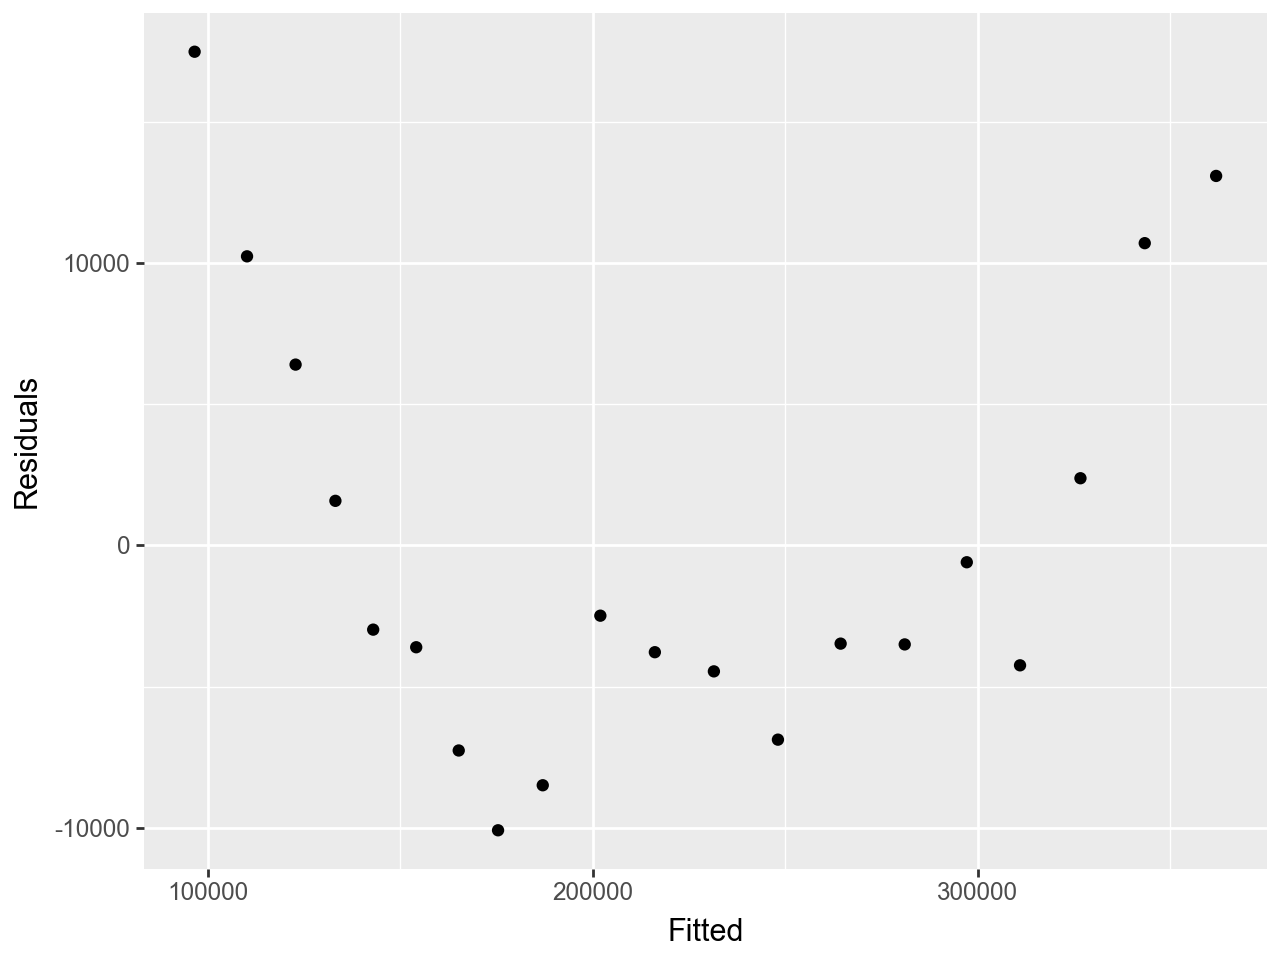

In [5]:
fitted_values = results.fittedvalues
residuals = results.resid
df = pd.DataFrame({'Fitted': fitted_values,
'Residuals': residuals})
plot = (
    ggplot(df,
    aes(x='Fitted', y='Residuals')) +
    geom_point()
)
plot.show()

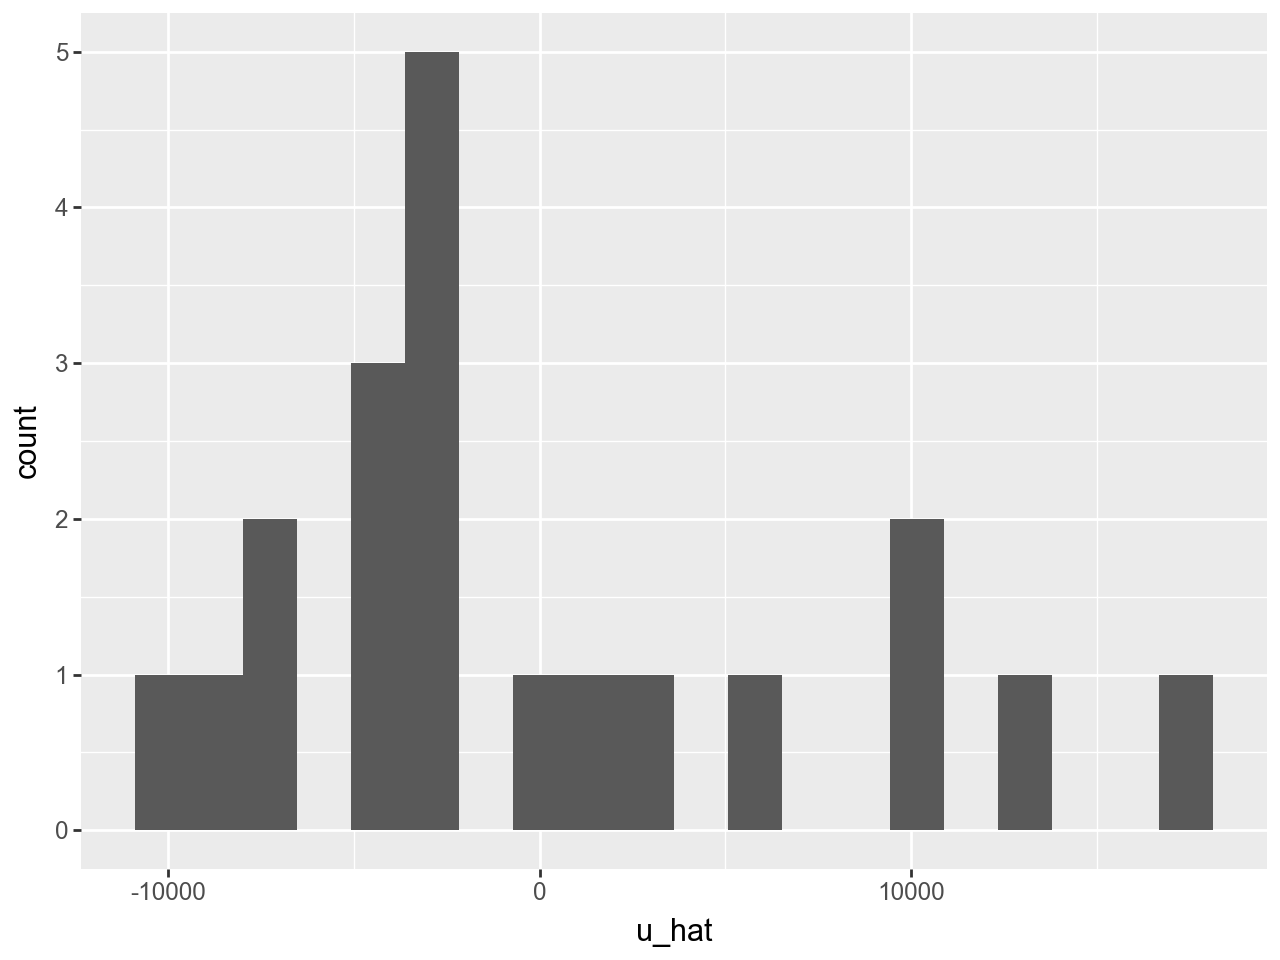

In [6]:
yhat = results.predict(X)
uhat = data['income'] - yhat
df = pd.DataFrame({'u_hat': uhat})
plot = (
ggplot(df,
aes(x='u_hat')) +
geom_histogram(bins = 20)
)

plot.show()

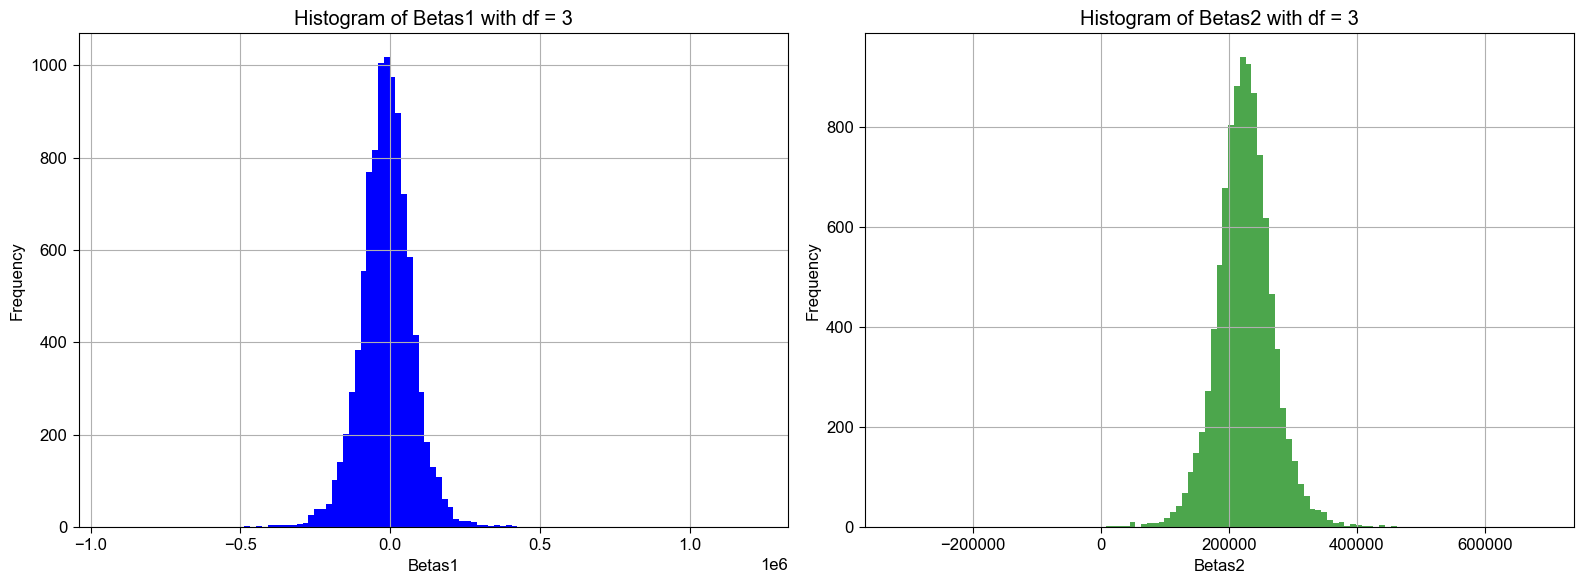

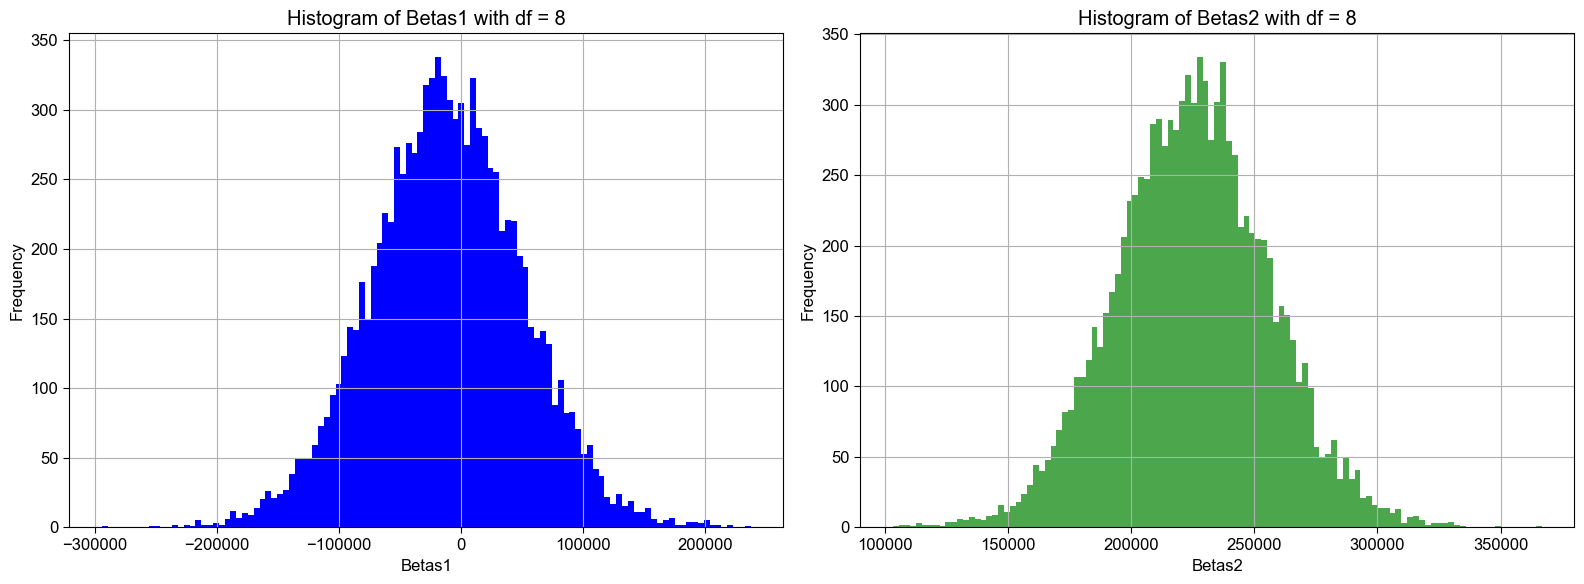

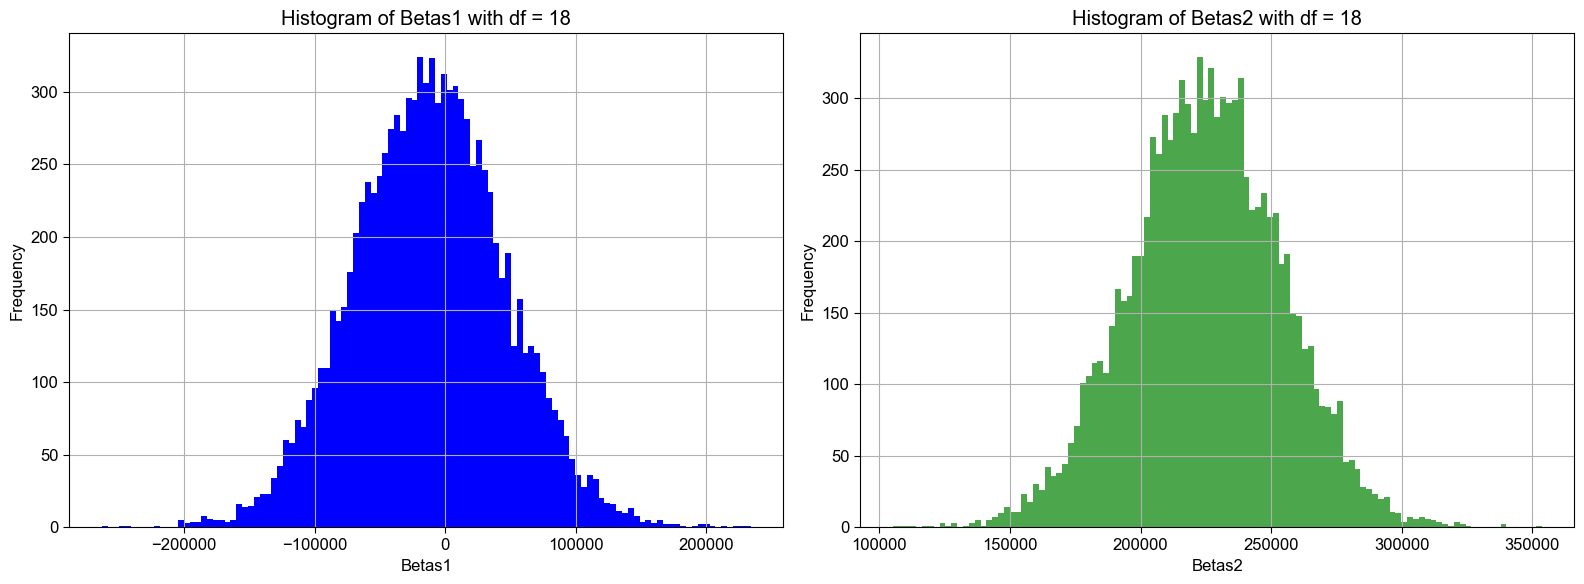

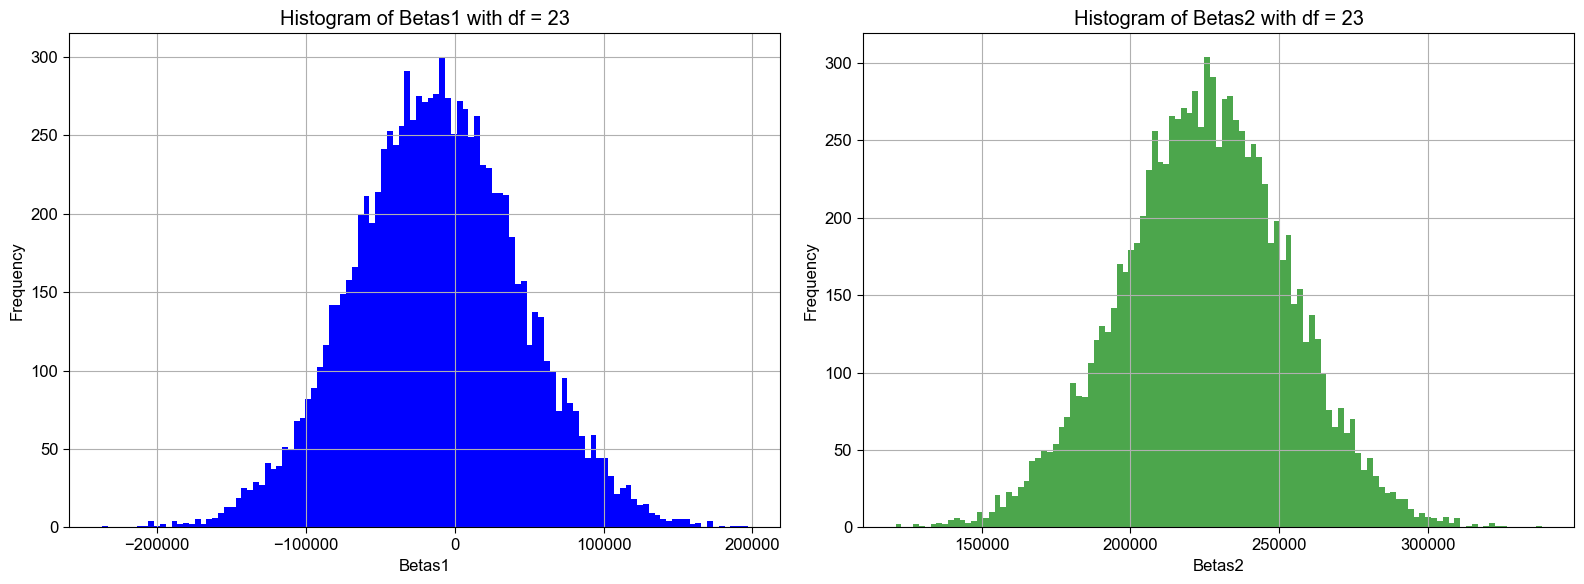

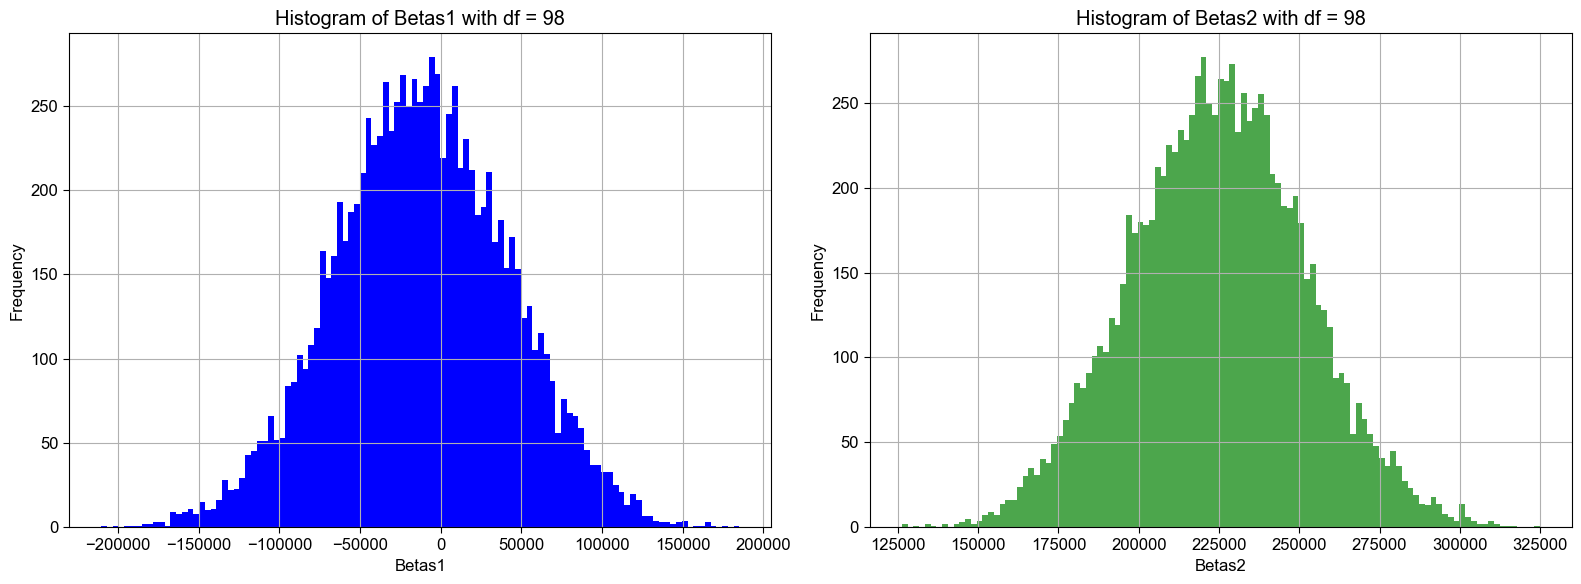

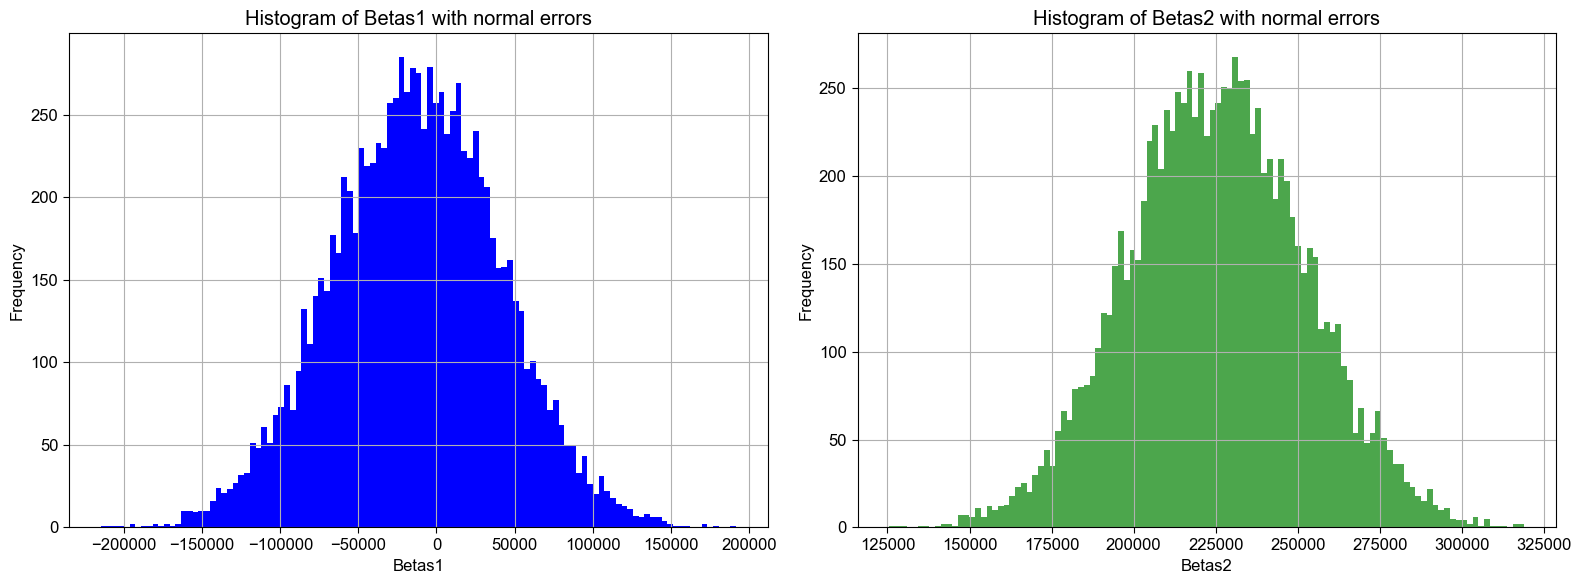

In [25]:
df_list = [5,10,20,25,100]

df_mean = []

for df in df_list + ["normal"]:
    MC = 10000
    BS = len(data)
    if df != "normal":
        df = df - 2

    y_vec = np.full((MC, BS),np.nan)
    betas0 = np.full(MC,np.nan)
    betas1 = np.full(MC,np.nan)
    betas2 = np.full(MC,np.nan)
    sdu = result = np.sqrt(np.sum((uhat ** 2) / (BS - 3)))

    for mc in range(MC):
        if df == "normal":
            u_normal = np.random.normal(size=BS) * sdu
            u_error = u_normal
        else:
            u_t = t.rvs(df, size=BS) * sdu
            u_error = u_t
        # MC
        y_tmp = results.params[0] +  results.params[1]*data['ln_capital']  + results.params[2]*data['ln_labor'] + u_error

        y_vec[mc, :] = y_tmp
        # Fit the model
        X_tmp = sm.add_constant(np.column_stack((data['ln_capital'], data['ln_labor'])))
        # Add a constant to the array
        fit_tmp = sm.OLS(y_tmp, X_tmp).fit()
        betas0[mc] = fit_tmp.params[0]
        betas1[mc] = fit_tmp.params[1]
        betas2[mc] = fit_tmp.params[2]

    betas_df = pd.DataFrame(
        {'betas0': betas0,
        'betas1':betas1,
        'betas2':betas2}
    )

    df_mean.append({
        'betas0': betas_df['betas0'].mean(),
        'betas1': betas_df['betas1'].mean(),
        'betas2': betas_df['betas2'].mean()
    })
    
    # Create a figure and axis with subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1 - Histogram of Betas1
    if df == "normal":
        axs[0].hist(betas1, bins=int(500/(BS**0.5)), color='blue', alpha=1)
        axs[0].set_xlabel('Betas1')
        axs[0].set_ylabel('Frequency')
        axs[0].set_title('Histogram of Betas1 with normal errors')
        axs[0].grid(True)

        # Plot 2 - Histogram of Betas2
        axs[1].hist(betas2, bins=int(500/(BS**0.5)), color='green', alpha=0.7)
        axs[1].set_xlabel('Betas2')
        axs[1].set_ylabel('Frequency')
        axs[1].set_title('Histogram of Betas2 with normal errors')
        axs[1].grid(True)

    else:
        axs[0].hist(betas1, bins=int(500/(BS**0.5)), color='blue', alpha=1)
        axs[0].set_xlabel('Betas1')
        axs[0].set_ylabel('Frequency')
        axs[0].set_title(f'Histogram of Betas1 with df = {df}')
        axs[0].grid(True)

        # Plot 2 - Histogram of Betas2
        axs[1].hist(betas2, bins=int(500/(BS**0.5)), color='green', alpha=0.7)
        axs[1].set_xlabel('Betas2')
        axs[1].set_ylabel('Frequency')
        axs[1].set_title(f'Histogram of Betas2 with df = {df}')
        axs[1].grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


In [34]:
df_mean = pd.DataFrame(df_mean)
results_params = pd.DataFrame(results.params)

df_mean["ratio_betas0"] = df_mean["betas0"] / float(results_params.iloc[0])
df_mean["ratio_betas1"] = df_mean["betas1"] / float(results_params.iloc[1])
df_mean["ratio_betas2"] = df_mean["betas2"] / float(results_params.iloc[2])

df_mean_copy = df_mean.copy()
df_mean_copy.index = [f"t({df})" for df in df_list] + ["normal"]
display(df_mean_copy)

,betas0,betas1,betas2,ratio_betas0,ratio_betas1,ratio_betas2
t(5),-2.520470e+06,-11609.173451,224708.008318,1.000929,0.960968,0.999276
t(10),-2.519533e+06,-11711.114356,224711.329254,1.000556,0.969407,0.999291
t(20),-2.520545e+06,-11960.095412,224971.875126,1.000958,0.990016,1.000449
t(25),-2.517731e+06,-12200.680294,224926.320853,0.999841,1.009931,1.000247
t(100),-2.518690e+06,-11549.526499,224524.853720,1.000222,0.956031,0.998462
normal,-2.516357e+06,-12807.098197,225265.015836,0.999295,1.060128,1.001753


The regression results present estimated coefficients for different parameters under various t-distribution values and a normal distribution. While the estimates for the constant term, ln_capital, and ln_labor coefficients generally approximate the real values of -2.518 million, -12,081, and 224,871 respectively, with minor variations across different t-distributions, the ratios of the estimated coefficients to the real values hover close to 1, indicating overall accuracy in estimation. This suggests that the model provides reliable parameter estimates, capturing the underlying relationships between the variables adequately across different distributional assumptions.




In [55]:
X

,ln_capital,ln_labor
0,9.025215,12.112383
1,9.051227,12.174319
2,9.075437,12.231701
3,9.099632,12.278998
4,9.123802,12.323949
5,9.166284,12.375925
6,9.161885,12.424794
7,9.175956,12.470976
8,9.243195,12.526219
9,9.303922,12.596011


In [66]:
chosen_estimators = df_mean.loc[4]
chosen_estimators = chosen_estimators.drop(['ratio_betas0', 'ratio_betas1', 'ratio_betas2'])


y_estimated = chosen_estimators[0] + chosen_estimators[1] * data['ln_capital'] + chosen_estimators[2] * data['ln_labor']

u_estimated = data["income"] - y_estimated

variance = np.matmul(u_estimated, u_estimated.T) / (100 - 3)

var_B = variance * np.linalg.inv(np.matmul(X.T, X))

standart_error = np.sqrt(np.diag(var_B))

# Question 2

In [79]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['ln_capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['ln_capital', 'ln_labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M1_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M1_MSE}')

Mean Squared Error: 1812306775.8674698


In [80]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['capital', 'labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['capital', 'labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M2_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M2_MSE}')

Mean Squared Error: 92448940.45616627


In [81]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['capital', 'ln_labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M3_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M3_MSE}')

Mean Squared Error: 972141750.53673


In [82]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['ln_capital', 'labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['ln_capital', 'labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M4_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M4_MSE}')

Mean Squared Error: 64919212.82749287


In [85]:
mse_df = pd.DataFrame({
    'MSE': [M1_MSE, M2_MSE, M3_MSE, M4_MSE]
})
mse_df.index = ['M1', 'M2', 'M3', 'M4']

display(mse_df)

,MSE
M1,1.812307e+09
M2,9.244894e+07
M3,9.721418e+08
M4,6.491921e+07


## Summary and Comments on Linear Regression Models

### Model Performance Comparison

| Model | Independent Variables | Mean Squared Error (MSE) |
|-------|------------------------|---------------------------|
| M1    | ln_capital, ln_labor   | 1.812307e+09              |
| M2    | capital, labor         | 9.244894e+07              |
| M3    | capital, ln_labor      | 9.721418e+08              |
| M4    | ln_capital, labor      | 6.491921e+07              |

### Comments

- **Model Selection**: Based on MSE alone, Model 4 (M4) performs the best among the tested models with the lowest MSE. Model 2 (M2) also shows relatively low MSE compared to the others.
  
- **Variable Transformation**: It's apparent that transforming variables (taking the natural logarithm) in Model 1 and Model 3 did not improve model performance compared to using the original variables.
  
- **Variable Combination**: The combination of variables in Model 4 seems to capture the relationship between income and the predictors effectively, resulting in the lowest MSE.
  
- **Interpretation**: The results suggest that there might be a nonlinear relationship between income and capital (or labor), which is better captured by Model 4 compared to the other models.
  
- **Further Analysis**: It could be beneficial to explore other variable combinations, interactions, or polynomial terms to potentially improve model performance further. Additionally, considering diagnostic checks for model assumptions and multicollinearity could enhance the robustness of the analysis.


# Question 3

In [102]:
# Leave-One-Out Cross-Validation (LOOCV)

# Define the model 1
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['ln_capital', 'ln_labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['ln_capital', 'ln_labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['ln_capital'] + results.params[2] * test_data['ln_labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m1 = np.mean(errors)

print("LOOCV Error for Model 1:", loocv_error_m1)


LOOCV Error for Model 1: 909436950.8733288


In [103]:
# Define the model 2
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['capital', 'labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['capital', 'labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['capital'] + results.params[2] * test_data['labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m2 = np.mean(errors)

print("LOOCV Error for Model 2:", loocv_error_m2)


LOOCV Error for Model 2: 47458905.42439395


In [104]:
# Define the model 3
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['capital', 'ln_labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['capital', 'ln_labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['capital'] + results.params[2] * test_data['ln_labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m3 = np.mean(errors)

print("LOOCV Error for Model 3:", loocv_error_m3)


Mean Squared Error: 5811446.120075511
Mean Squared Error: 54193.918005681495
Mean Squared Error: 946505.7529739558
Mean Squared Error: 913684.0474872167
Mean Squared Error: 9523586.455270343
Mean Squared Error: 15424797.905059304
Mean Squared Error: 901444.0511887542
Mean Squared Error: 6374001.691737132
Mean Squared Error: 1652769.4417377913
Mean Squared Error: 4684816.381731983
Mean Squared Error: 21085908.151033588
Mean Squared Error: 98235957.47182582
Mean Squared Error: 349568484.86983174
Mean Squared Error: 524824121.831549
Mean Squared Error: 891023093.0735816
Mean Squared Error: 950373711.8686837
Mean Squared Error: 850032435.6644825
Mean Squared Error: 1499023684.6921744
Mean Squared Error: 226543733.05545524
Mean Squared Error: 4310706374.68869
LOOCV Error for Model 3: 488385237.5566288


In [105]:
# Define the model
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['ln_capital', 'labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['ln_capital', 'labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['ln_capital'] + results.params[2] * test_data['labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m4 = np.mean(errors)

print("LOOCV Error for Model 4:", loocv_error_m4)


Mean Squared Error: 6085589.783757292
Mean Squared Error: 220994.01383455118
Mean Squared Error: 1428618.8144098036
Mean Squared Error: 462321.1508254499
Mean Squared Error: 7808102.226133355
Mean Squared Error: 8109950.945492506
Mean Squared Error: 7774.788924397392
Mean Squared Error: 151335.4574685318
Mean Squared Error: 1845974.8111526198
Mean Squared Error: 10546991.165825257
Mean Squared Error: 1606349.6561410676
Mean Squared Error: 39155353.422303125
Mean Squared Error: 79849649.67926706
Mean Squared Error: 113725895.84376013
Mean Squared Error: 133584310.45894526
Mean Squared Error: 95032200.97475067
Mean Squared Error: 11013418.240570003
Mean Squared Error: 39113430.0972585
Mean Squared Error: 46668829.90016899
Mean Squared Error: 89442690.00176226
LOOCV Error for Model 4: 34292989.07163754


In [106]:
loocv_df = pd.DataFrame({
    'MSE': [loocv_error_m1, loocv_error_m2, loocv_error_m3, loocv_error_m4]
})
loocv_df.index = ['M1', 'M2', 'M3', 'M4']

display(loocv_df)

,MSE
M1,9.094370e+08
M2,4.745891e+07
M3,4.883852e+08
M4,3.429299e+07


# Leave-One-Out Cross-Validation (LOOCV)

## Model Evaluation

### Model 1 (ln_capital, ln_labor)
- **MSE:** 9.094370e+08

The average error (MSE) for Model 1 is quite high, indicating poor performance in predicting income. This could suggest that using the natural logarithm of capital and labor as predictors might not capture the relationship with income adequately.

### Model 2 (capital, labor)
- **MSE:** 4.745891e+07

The average error for Model 2 is considerably lower compared to Model 1. This suggests that using the original variables without taking their logarithms results in a better prediction of income. It's possible that the original scale of capital and labor better represents their relationship with income in this context.

### Model 3 (capital, ln_labor)
- **MSE:** 4.883852e+08

The average error for Model 3 is higher than that of Model 2 but lower than that of Model 1. This indicates that while using the original scale for capital is beneficial, taking the natural logarithm of labor might not improve the prediction of income as much as using the original scale for both variables.

### Model 4 (ln_capital, labor)
- **MSE:** 3.429299e+07

The average error for Model 4 is the lowest among all models. This suggests that using the natural logarithm of capital along with the original scale of labor results in the best prediction of income among the models tested. It appears that taking the logarithm of capital captures its relationship with income effectively, while using the original scale for labor is preferable.

## Summary
Based on LOOCV, Model 4 (ln_capital, labor) performs the best in predicting income, followed by Model 2 (capital, labor), Model 3 (capital, ln_labor), and lastly Model 1 (ln_capital, ln_labor). These findings provide insights into which combination of predictor variables yields the most accurate predictions of income in this context.


In [114]:
# Define the model 1
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['ln_capital', 'ln_labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m1_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m1_k4 = np.mean(errors_k4)


In [115]:
# Define the model 2
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['capital', 'labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m2_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m2_k4 = np.mean(errors_k4)


In [116]:
# Define the model 3
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['capital', 'ln_labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m3_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m3_k4 = np.mean(errors_k4)


In [117]:
# Define the model 4
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['ln_capital', 'labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m4_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m4_k4 = np.mean(errors_k4)


In [118]:
k_fold_df = pd.DataFrame({
    'k=2': [loocv_error_m1_k2, loocv_error_m2_k2, loocv_error_m3_k2, loocv_error_m4_k2],
    'k=4': [loocv_error_m1_k4, loocv_error_m2_k4, loocv_error_m3_k4, loocv_error_m4_k4]
})
k_fold_df.index = ['M1', 'M2', 'M3', 'M4']

display(k_fold_df)

,k=2,k=4
M1,1.146490e+09,2.411299e+08
M2,3.021337e+08,1.683934e+08
M3,6.968058e+08,2.126814e+08
M4,2.812487e+08,1.109897e+08


# Question 5

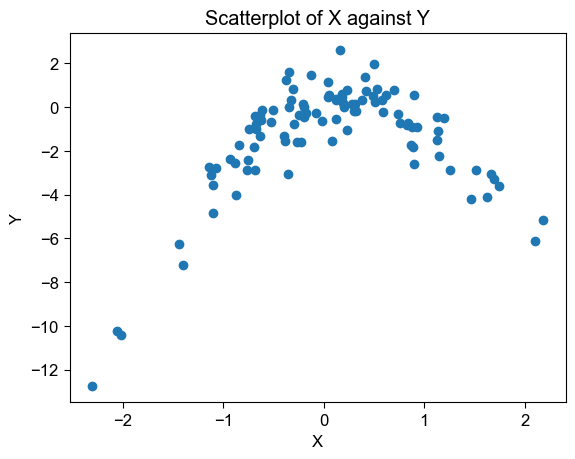

In [125]:
np.random.seed(1)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Create a scatterplot of X against Y.
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot of X against Y')
plt.show()

### Analysis of Scatter Plot

1. **Non-linear Relationship**: The relationship between X and Y appears to be non-linear, as indicated by the curvature in the scatter plot. This is expected because of the quadratic term in the generation of the Y variable (`-2 * x**2`).

2. **Centered around X-axis**: The majority of the data points seem to be concentrated around the X-axis, particularly for larger values of X. This is likely due to the negative quadratic term in the generation of Y, which tends to pull the values downward as X increases.

3. **Scattered Distribution**: While there's a general trend, the data points are quite scattered, indicating variability in Y for any given value of X. This variability could be due to the random noise added during the generation of both X and Y.

4. **Overall Trend**: Despite the scatter, there's still a discernible downward trend as X increases, reflecting the influence of the quadratic term in the generation of Y.

5. **Randomness**: The presence of random noise in both X and Y adds stochasticity to the relationship, making it difficult to predict Y precisely for a given X.

Overall, the scatter plot effectively visualizes the relationship between X and Y, highlighting the non-linear nature of their association and the presence of random variability.


In [136]:
# Generate data
np.random.seed(1)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Reshape x and y for sklearn
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Initialize LOOCV
loo = LeaveOneOut()

# Initialize lists to store MSE values
mse_values = []

# Define degrees for polynomial regression
degrees = [1, 2, 3, 4]

# Iterate over degrees
for degree in degrees:
    # Initialize list to store errors for each degree
    errors = []
    
    # Fit the model and compute LOOCV errors
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        
        # Predict the left-out data point
        y_pred = model.predict(x_test_poly)
        
        # Compute error
        error = mean_squared_error(y_test, y_pred)
        errors.append(error)
    
    # Calculate mean squared error (MSE) for the current degree
    mse = np.mean(errors)
    mse_values.append(mse)

# Print MSE values for each degree
for degree, mse in zip(degrees, mse_values):
    print(f"Degree {degree}: Mean Squared Error (MSE) of LOOCV = {mse}")

Degree 1: Mean Squared Error (MSE) of LOOCV = 6.260764331604616
Degree 2: Mean Squared Error (MSE) of LOOCV = 0.9142897072803663
Degree 3: Mean Squared Error (MSE) of LOOCV = 0.9268768781648808
Degree 4: Mean Squared Error (MSE) of LOOCV = 0.8669116865881078


In [137]:
# Generate data
np.random.seed(1312312)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Reshape x and y for sklearn
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Initialize LOOCV
loo = LeaveOneOut()

# Initialize lists to store MSE values
mse_values = []

# Define degrees for polynomial regression
degrees = [1, 2, 3, 4]

# Iterate over degrees
for degree in degrees:
    # Initialize list to store errors for each degree
    errors = []
    
    # Fit the model and compute LOOCV errors
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        
        # Predict the left-out data point
        y_pred = model.predict(x_test_poly)
        
        # Compute error
        error = mean_squared_error(y_test, y_pred)
        errors.append(error)
    
    # Calculate mean squared error (MSE) for the current degree
    mse = np.mean(errors)
    mse_values.append(mse)

# Print MSE values for each degree
for degree, mse in zip(degrees, mse_values):
    print(f"Degree {degree}: Mean Squared Error (MSE) of LOOCV = {mse}")

Degree 1: Mean Squared Error (MSE) of LOOCV = 8.31720136699923
Degree 2: Mean Squared Error (MSE) of LOOCV = 1.1203553673267843
Degree 3: Mean Squared Error (MSE) of LOOCV = 1.1257131831742606
Degree 4: Mean Squared Error (MSE) of LOOCV = 1.1559225588601576


The results in (d) are different from those in (c), which is expected. This discrepancy arises due to the random nature of data generation and the LOOCV process.

In both (c) and (d), new random data sets `x` and `y` are generated using different random seeds (`1` in (c) and `1312312` in (d)). These random seeds lead to different random numbers being generated, resulting in different datasets.

Since LOOCV involves leaving out one data point at a time for validation, the specific data points left out for validation will differ between the two runs. Consequently, the fitted models and resulting errors will vary.

The differences between the two sets of results illustrate the variability introduced by random data generation and the LOOCV procedure.


### Analysis of Polynomial Orders and Mean Squared Error (MSE)

- The 4th order polynomial exhibits the most thoughtful MSE.

- Initially, one might anticipate higher MSE for polynomial orders lower or higher than 2nd, given that our data is generated using a 2nd order polynomial. However, due to the involvement of randomization, deviations from this expectation are common.

- Surprisingly, the 4th order polynomial did not yield the anticipated higher MSE typically associated with overfitting. This unexpected result warrants further investigation.